## Calculation of SPsd for A370 BUFFALO reconstruction:

In [1]:
import glob
import sys
import numpy as np
import operator
from scipy import optimize
from scipy import stats
from scipy.ndimage import gaussian_filter
import math
from scipy.interpolate import RegularGridInterpolator

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

c = 2.9979e10 #speed of light
G = 6.6726e-8 #Gravitational constant in cgs
m_sol = 1.989e33 #Solar mass in grams
rad_arcs = 206264.806 #Conversion factor for going from radians to arcseconds


plummers = np.genfromtxt('invX_plummers.dat', dtype=(
    {'names': ['x', 'y', 'width', 'mass'], 'formats': ['f8', 'f8', 'f8', 'f8']}))
px=plummers['x']
py=plummers['y']
pmass=plummers['mass']
pwidth=plummers['width']

plumno = np.genfromtxt('plum_no.dat', dtype=(
    {'names': ['no'],'formats': ['i4']}))

mult = np.genfromtxt('images02_mult.dat', dtype=(
    {'names': ['no'],'formats': ['i4']}))

img = np.genfromtxt('images02.dat', dtype=(
    {'names': ['tag', 'x', 'y', 'z'], 'formats': ['f8', 'f8', 'f8', 'f8']}))

N = len(img['x']) #Number of images


In [2]:
################
class constants:
#---------------
	'''
	class of cosmology constants
	'''
    ##########################################
	def __init__(self, omega_m, omega_l, H_0):
    #-----------------------------------------
		self.omega_m = omega_m 					#matter density
		self.omega_l = omega_l					#dark energy density / lambda
		self.omega_k = 1.0 - omega_l - omega_m 	#curvature density, for flat normally zero
		self.H = H_0						#Hubble parameter today
		self.h = H_0/100.					#dimensionless Hubble parameter
		self.d_h = 299792.458/H_0			#Hubble distance, c/H_0 with c in units of km * s^-1


################
class distances:
#---------------
	'''
	class of different distances in cosmology
	'''
    ################################
	def codist(self, z1, z2, cosmo):
    #-------------------------------
		'''
		This function calculates the comoving distance d_c in units of Mpc.
		z1, z2 :: redshifts with z1<z2
		cosmo  :: class of cosmology constants (omega_m, omega_l, h, etc.)
		d_c    :: comoving distance
		'''
		dz = 0.0001
		z = z1 + 0.5 * dz
		d_c = 0.0
		while(z < z2):
			f = 1.0 + z
			demon = cosmo.omega_m * f**3 + cosmo.omega_k * f**2 + cosmo.omega_l
			d_c += dz / np.sqrt(demon)
			z += dz
		return d_c*cosmo.d_h
    ######################################
	def tcodist(self, z1, z2, d_c, cosmo):
    #-------------------------------------
		'''
		This function calculates the transverse comoving distance d_M in units of Mpc.
		z1, z2	:: redshifts with z1<z2
		cosmo	:: class of cosmology constants (omega_m, omega_l, h, etc.)
		d_c		:: comoving distance
		d_M		:: transverse comoving distance
		'''
		d_M = 0.0
		f = np.sqrt(np.abs(cosmo.omega_k))
		if(cosmo.omega_k > 0.0):
			d_M = cosmo.d_h/f*np.sinh(f*d_c/cosmo.d_h)
			#print 'Omega_k > 0'
		elif(cosmo.omega_k < 0.0):
			d_m = cosmo.d_h/f*np.sin(f*d_c/cosmo.d_h)
			#print 'Omega_k < 0'
		else:
			d_M = d_c
		return d_M
    ###############################
	def angdist(self, d_M, z, d_A):
    #------------------------------
		'''
		This function calculates the angular diameter distance d_M in units of Mpc.
		z1		:: redshift z
		d_M		:: transverse comoving distance
		d_A		:: angular diameter distance
		'''
		d_A = 0.0
		d_A = d_M/(1.0+z)
		return d_A

In [3]:
pwd

'/Users/agnivaghosh/Downloads/Lensing/mag/A370_hff'

In [4]:
# First thing is to get angular diameter distances and critical surface densities for every image

#Constants
c = 2.9979e10 #speed of light
G = 6.6726e-8 #Gravitational constant in cgs
m_sol = 1.989e33 #Solar mass in grams
rad_arcs = 206264.806 #Conversion factor for going from radians to arcseconds

# Define cosmology.
cosmo = constants(0.3, 0.7, 70)

# Define redshifts
z_o = 0.0  # observer redshift
z_l = 0.375  # lens redshift for Abell 2744

# Initialize angular diameter arrays
d_ol = np.zeros(N)
d_ls = np.zeros(N)
d_os = np.zeros(N)
scrit = np.zeros(N)

#Check Curvature is near zero
print ("Omega_k: ", cosmo.omega_k)

d_c, d_M, d_A = 0.0, 0.0, 0.0  # Initialize distances
dist = distances()  # create cosmology.distance instance

# For loop over images to calculate the angular diameter distances and critical surface densities.
for i in range(N):
    z_s = img['z'][i]

    # Calculate the observer to lens ang dist.
    d_c = dist.codist(z_o, z_l, cosmo)
    d_M = dist.tcodist(z_o, z_l, d_c, cosmo)
    d_A = dist.angdist(d_M, z_l, d_A)

    d_ol[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    # Calculate the lens to source ang dist.
    d_c = dist.codist(z_l, z_s, cosmo)
    d_M = dist.tcodist(z_l, z_s, d_c, cosmo)
    d_A = dist.angdist(d_M, z_s, d_A)

    d_ls[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    # Calculate the observer to source ang dist.
    d_c = dist.codist(z_o, z_s, cosmo)
    d_M = dist.tcodist(z_o, z_s, d_c, cosmo)
    d_A = dist.angdist(d_M, z_s, d_A)

    d_os[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    #Calculate critical surface density
    scrit[i] = c**2/(4*np.pi*G)*d_os[i]/d_ol[i]/d_ls[i]
    
print(scrit)



Omega_k:  5.551115123125783e-17
[0.68405016 0.68405016 0.68405016 0.7549841  0.7549841  0.7549841
 0.7549841  0.7549841  0.45704271 0.45704271 0.45704271 0.52082654
 0.52082654 0.52082654 0.5200701  0.5200701  0.5200701  0.5200701
 0.5661126  0.5661126  0.5661126  0.42911085 0.42911085 0.42911085
 0.42911085 0.42911085 0.48904266 0.48904266 0.48904266 0.42911085
 0.42911085 0.42911085 0.41604318 0.41604318 0.41604318 0.40755569
 0.40755569 0.40755569 0.4215132  0.4215132  0.4215132  0.4215132
 0.4215132  0.41312291 0.41312291 0.41312291 0.41312291 0.41312291
 0.41235008 0.41235008 0.41235008 0.40746648 0.40746648 0.40746648
 0.4059916  0.4059916  0.4059916  0.39825095 0.39825095 0.39825095
 0.39776034 0.39776034 0.52353681 0.52353681 0.52353681 0.4215132
 0.4215132  0.4215132  0.39689357 0.39689357 0.39689357 0.40243089
 0.40243089 0.41196096 0.41196096 0.41196096 0.41057057 0.41057057
 0.41057057 0.42354142 0.42354142 0.42354142 0.42560889 0.42560889
 0.42560889 0.40550706 0.40550706 

In [5]:
print(img['z'][0])

0.8041


84913


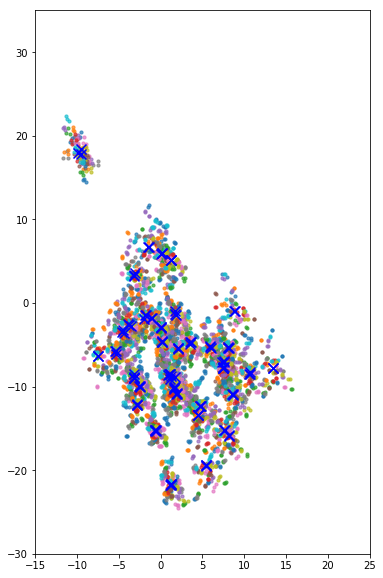

In [5]:
#Open file to save back-projected or source positions
# f_src = open('source_pos.txt', 'w', 0)
# import seaborn as sns
P=len(plummers)
print(P)
N = len(img['x']) #Number of images

defl = np.zeros((2,N,40))
beta = np.zeros((2,N,40))
image = np.zeros(2)
m= [0 for n in range(41)]
m[0]=0
    

factor = 4*G/c**2 #4G/c^2 in cgs
#For loop over images to calculate source positions

fig, ax = plt.subplots(figsize=(10, 10))
import time
for j in range(40):
    m[j+1]=plumno['no'][j]+m[j]
    print (j, end="\r")
    
    for k in range(N):
        image[0],image[1]=img['x'][k]-8.801683125504965,img['y'][k]+0.2499983999999067
#         image[0],image[1]=img['x'][k],img['y'][k]
        D=d_ls[k]/d_ol[k]/d_os[k]
        defl[0,k,j], defl[1,k,j] = 0., 0.
        for i in range(m[j],m[j+1]):
            defl[0,k,j] += factor*m_sol*pmass[i]*D*(image[0]-px[i])/((image[0]-px[i])**2+(image[1]-py[i])**2+(pwidth[i])**2)*rad_arcs**2 
            defl[1,k,j] += factor*m_sol*pmass[i]*D*(image[1]-py[i])/((image[0]-px[i])**2+(image[1]-py[i])**2+(pwidth[i])**2)*rad_arcs**2
            beta[0,k,j], beta[1,k,j]=image[0] - defl[0,k,j], image[1] - defl[1,k,j] #lens equation
    ax.scatter(beta[0,:,j],beta[1,:,j],alpha=0.7,s=10)
#     sns.scatterplot(data=beta)

avgbeta=np.average(beta,axis=2)

ax.scatter(avgbeta[0],avgbeta[1],s=100,color='b',marker='x')
ax.set_aspect('equal')

plt.axis([-15,25,-30,35])
# plt.legend(loc='upper right')
plt.show()
fig.savefig('Back_Projected_A370_HFF.pdf', dpi=300, transparent=True,bbox_inches='tight')
        
            
            

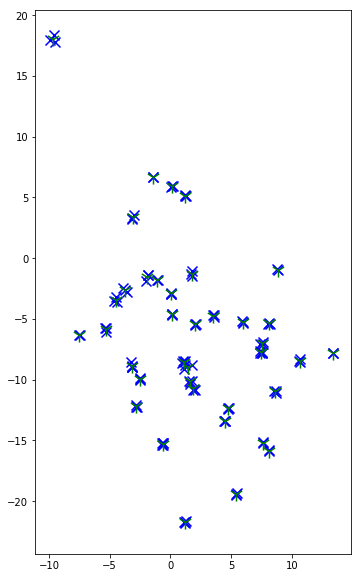

In [7]:
src = np.genfromtxt('back_projected_sources.dat', dtype=(
    {'names': ['srctag','x','y','z','mult' ], 'formats': ['i4','f8', 'f8', 'f8','f8']}))

src_allim = np.genfromtxt('back_projected_sources_allim.dat', dtype=(
    {'names': ['srctag','x','y'], 'formats': ['i4','f8', 'f8']}))

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(avgbeta[0],avgbeta[1],s=100,marker='x',color='b')

# ax.scatter(src_allim['x'],src_allim['y'],s=50,marker='x',color='b',alpha=0.5)
ax.scatter(src['x'],src['y'],s=200,marker='1',color='g')
ax.set_aspect('equal')
plt.axis()
plt.show()

In [11]:
m= [0 for n in range(41)]
umass=np.zeros((40,2),dtype=(int,float))
lmass=np.zeros((40,2),dtype=(int,float))
massr=np.zeros((40,1),dtype=(float))

m[0]=0
for i in range(40):
    m[i+1]=plumno['no'][i]+m[i]
#     print(m[i+1])
    umass[i,0]=i+1
    lmass[i,0]=i+1
#     massr[i,0]=i+1
    
    for j in range(m[i],m[i+1]):
        if plummers['y'][j]<-50:
            lmass[i,1]+=plummers['mass'][j]
        if plummers['y'][j]>50:
            umass[i,1]+=plummers['mass'][j]
    massr[i,0]=umass[i,1]/lmass[i,1]
# mass=list(enumerate(mass))

In [6]:
m= [0 for n in range(41)]
umass=np.zeros((40,2),dtype=(int,float))
lmass=np.zeros((40,2),dtype=(int,float))
mass=np.zeros((40,2),dtype=(int,float))
massr=np.zeros((40,1),dtype=(float))

m[0]=0
for i in range(40):
    m[i+1]=plumno['no'][i]+m[i]
#     print(m[i+1])
    umass[i,0]=i+1
    lmass[i,0]=i+1
    mass[i,0]=i+1
#     massr[i,0]=i+1
    
    for j in range(m[i],m[i+1]):
        mass[i,1]+=plummers['mass'][j]
        if plummers['y'][j]<-50:
            lmass[i,1]+=plummers['mass'][j]
        if plummers['y'][j]>50:
            umass[i,1]+=plummers['mass'][j]
        
    massr[i,0]=(umass[i,1]-lmass[i,1])/mass[i,1]
# mass=list(enumerate(mass))

In [7]:
del_y = np.zeros((len(img['x']),40,2))
# fig, ax = plt.subplots(figsize=(8,8))
for j in range(40): 
    del_y[:,j,0]=j
    del_y[:,j,1]=(beta[1,:,j] - avgbeta[1,:])#/len(img['x'])
# ax.scatter(del_y[0,:,1],del_y[0,:,0])

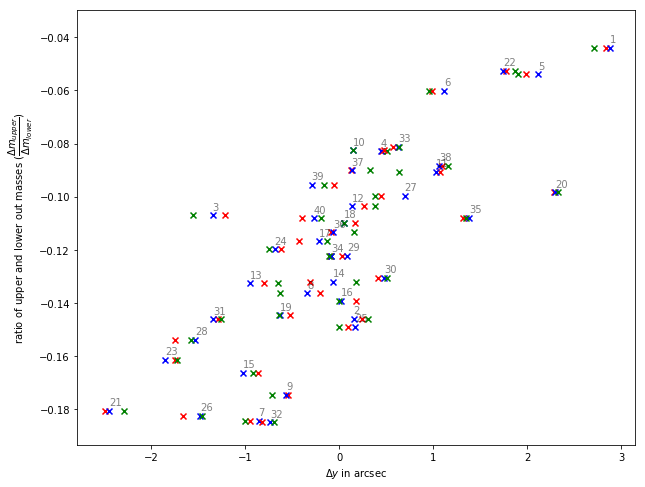

In [8]:
# import pandas as pd

# umass=np.zeros((40,2),dtype=(int,float))

# s=pd.DataFrame(del_y[2,:,1])
# u=pd.DataFrame(massr[0])
# std_y_table=s.sort_values(by=0, ascending=False)
# mass_table=u.sort_values(by=0, ascending=False)

fig, ax = plt.subplots(figsize=(10,8))

for j in range(40):
    ax.scatter(del_y[0,j,1],massr[j], color='red', marker='x')
    ax.scatter(del_y[1,j,1],massr[j], color='blue', marker='x')
    ax.scatter(del_y[2,j,1],massr[j], color='green', marker='x')
    ax.annotate(j+1,(del_y[1,j,1],massr[j]),xytext=(del_y[1,j,1]+0.0001,massr[j]+0.002),alpha=0.5)


# plt.scatter(del_y[0,:,1],massr, marker='x')
# plt.scatter(del_y[113,:,1],massr, marker='x')
# plt.scatter(del_y[19,:,1],massr, marker='x')

# z = np.polyfit(del_y[2,:,1], massr, 1)
# xp = np.linspace(0, 10, 100)
# p = np.poly1d(z)
# plt.plot(xp-5, p(xp-5),'g--')

plt.xlabel('$\Delta y$ in arcsec')
plt.ylabel('ratio of upper and lower out masses ($\dfrac{\Delta m_{upper}}{\Delta m_{lower}}$)')

# plt.title(p)

plt.show()

# fig.savefig('outermass_deltay_src1.png', dpi=900, transparent=True,bbox_inches='tight')


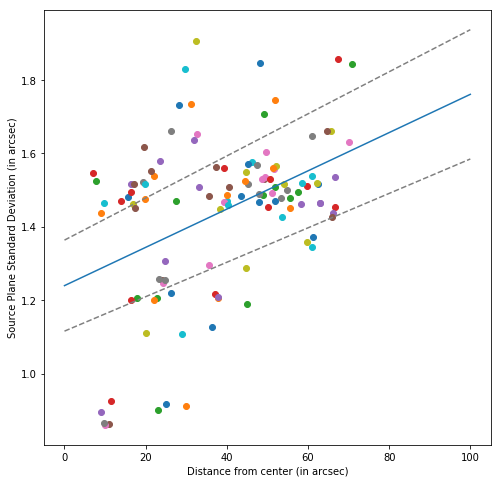

In [20]:
std_src = np.zeros((2,N))
std=np.zeros(N)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(N): 
    for j in range(40): 
        std_src[0,i]+=np.sqrt(abs(beta[0,i,j] - avgbeta[0,i])**2)/40
        std_src[1,i]+=np.sqrt(abs(beta[1,i,j] - avgbeta[1,i])**2)/40
    std[i]=np.sqrt(std_src[0,i]**2+std_src[1,i]**2)
    ax.scatter(np.sqrt((img['y'][i]+20)**2+(img['x'][i]-4)**2),std[i])
    
z = np.polyfit(np.sqrt((img['y']+20)**2+(img['x']-4)**2), std, 1)
xp = np.linspace(0, 100, 100)
p = np.poly1d(z)
plt.plot(xp, p(xp))
plt.plot(xp, 1.1*p(xp),'--',color='gray')
plt.plot(xp, 0.9*p(xp),'--',color='gray')
plt.axis()
# plt.yscale('log')
plt.xlabel("Distance from center (in arcsec)")
plt.ylabel("Source Plane Standard Deviation (in arcsec)")
plt.show()



         2
-0.5803 x + 1.093 x + 1.11


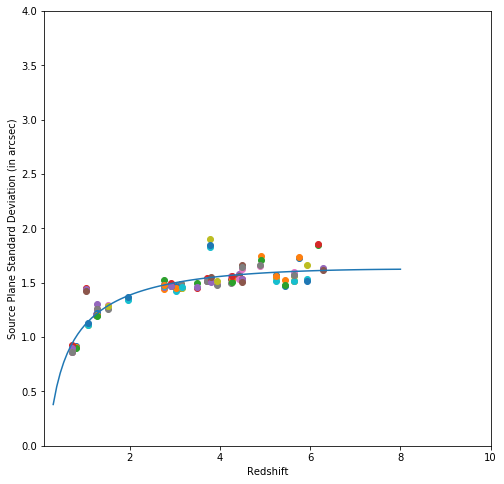

In [9]:
std_src = np.zeros((2,N))
std=np.zeros(N)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(N): 
    for j in range(40): 
        std_src[0,i]+=np.sqrt(abs(beta[0,i,j] - avgbeta[0,i])**2)/40
        std_src[1,i]+=np.sqrt(abs(beta[1,i,j] - avgbeta[1,i])**2)/40
    std[i]=np.sqrt(std_src[0,i]**2+std_src[1,i]**2)
#     print(std[i],img['z'][i])
    ax.scatter(img['z'][i],std[i])
    
z = np.polyfit(np.log10(img['z']), std,2)
xp = np.linspace(0.3, 8, 100)
p = np.poly1d(z)
print(p)
plt.plot(xp, p(np.log10(xp)))
plt.axis([0.1,10,0,4])
# plt.yscale('log')
plt.xlabel("Redshift")
plt.ylabel("Source Plane Standard Deviation (in arcsec)")
plt.show()
fig.savefig('SPsd_A370_HFF.pdf', dpi=300, transparent=True,bbox_inches='tight')

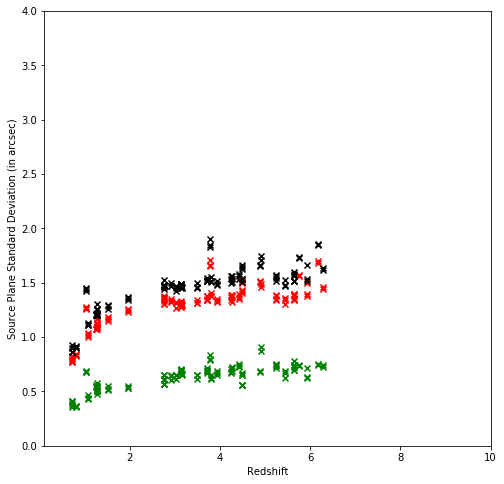

In [8]:
std_src = np.zeros((2,N))
std=np.zeros(N)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(N): 
    for j in range(40): 
        std_src[0,i]+=np.sqrt(abs(beta[0,i,j] - avgbeta[0,i])**2)/40
        std_src[1,i]+=np.sqrt(abs(beta[1,i,j] - avgbeta[1,i])**2)/40
    std[i]=np.sqrt(std_src[0,i]**2+std_src[1,i]**2)
#     print(std[i],img['z'][i])
    ax.scatter(img['z'][i],std[i],color='black',marker='x')
    ax.scatter(img['z'][i],std_src[0,i],color='green',marker='x')
    ax.scatter(img['z'][i],std_src[1,i],color='red',marker='x')
    
# plt.plot(z, 4*G/c**2*m_sol*d_ls/d_ol/d_os*2.23*10**22)
plt.axis([0.1,10,0,4])
# plt.yscale('log')
plt.xlabel("Redshift")
plt.ylabel("Source Plane Standard Deviation (in arcsec)")
plt.show()

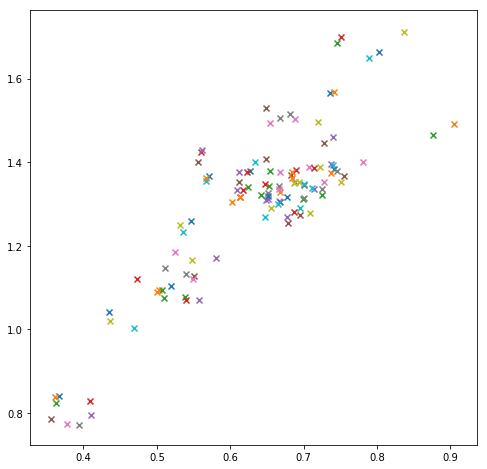

In [10]:
std_src = np.zeros((2,N))
std=np.zeros(N)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(N): 
    for j in range(40): 
        std_src[0,i]+=np.sqrt(abs(beta[0,i,j] - avgbeta[0,i])**2)/40
        std_src[1,i]+=np.sqrt(abs(beta[1,i,j] - avgbeta[1,i])**2)/40
    std[i]=np.sqrt(std_src[0,i]**2+std_src[1,i]**2)
#     print(std[i],img['z'][i])
    ax.scatter(std_src[0,i],std_src[1,i],marker='x')
    
# plt.plot(z, 4*G/c**2*m_sol*d_ls/d_ol/d_os*2.23*10**22)
plt.axis()
# plt.yscale('log')
# plt.xlabel("Redshift")
# plt.ylabel("Source Plane Standard Deviation (in arcsec)")
plt.show()


In [13]:
std

array([0.62252185, 0.78234379, 2.3687108 , 0.5256235 , 1.12331807,
       1.2333859 , 1.04613565, 1.79921413, 2.29410499, 0.67698616,
       0.95497865, 0.5597278 , 0.42502298, 0.82170988, 1.55615613,
       0.71473615, 1.42456408, 0.43348334, 0.49901961, 0.7048957 ,
       1.0590246 , 1.79252937, 0.73312303, 0.63190017, 1.01881962,
       0.5380052 , 1.43625563, 0.93867886, 0.95946967, 0.51412015,
       0.54755706, 0.91890498, 0.92128988, 0.55826836, 1.24140939,
       0.48810156, 0.77556294, 1.03495004, 0.67248201, 1.34799294])

In [14]:
import pandas as pd
s=pd.DataFrame(std)
print(s.sort_values(by=0, ascending=False))
s.dtypes


           0
2   2.368711
8   2.294105
7   1.799214
21  1.792529
14  1.556156
26  1.436256
16  1.424564
39  1.347993
34  1.241409
5   1.233386
4   1.123318
20  1.059025
6   1.046136
37  1.034950
24  1.018820
28  0.959470
10  0.954979
27  0.938679
32  0.921290
31  0.918905
13  0.821710
1   0.782344
36  0.775563
22  0.733123
15  0.714736
19  0.704896
9   0.676986
38  0.672482
23  0.631900
0   0.622522
11  0.559728
33  0.558268
30  0.547557
25  0.538005
3   0.525623
29  0.514120
18  0.499020
35  0.488102
17  0.433483
12  0.425023


0    float64
dtype: object

## Testing the z-dependence:

84913


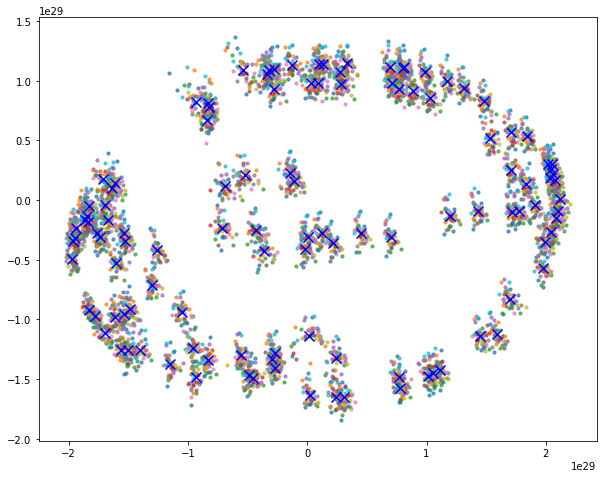

In [12]:
#Open file to save back-projected or source positions
# f_src = open('source_pos.txt', 'w', 0)
# import seaborn as sns
P=len(plummers)
print(P)
N = len(img['x']) #Number of images

defl = np.zeros((2,N,40))
beta = np.zeros((2,N,40))
image = np.zeros(2)
m= [0 for n in range(41)]
m[0]=0
    

factor = 4*G/c**2 #4G/c^2 in cgs
#For loop over images to calculate source positions

fig, ax = plt.subplots(figsize=(10, 10))
import time
for j in range(40):
    m[j+1]=plumno['no'][j]+m[j]
    print (j, end="\r")
    
    for k in range(N):
        image[0],image[1]=img['x'][k],img['y'][k]
        D=d_ls[k]/d_ol[k]/d_os[k]
        defl[0,k,j], defl[1,k,j] = 0., 0.
        for i in range(m[j],m[j+1]):
            defl[0,k,j] += factor*m_sol*pmass[i]*(image[0]-px[i])/((image[0]-px[i])**2+(image[1]-py[i])**2+(pwidth[i])**2)*rad_arcs**2 
            defl[1,k,j] += factor*m_sol*pmass[i]*(image[1]-py[i])/((image[0]-px[i])**2+(image[1]-py[i])**2+(pwidth[i])**2)*rad_arcs**2
            beta[0,k,j], beta[1,k,j]=image[0] - defl[0,k,j], image[1] - defl[1,k,j] #lens equation
    ax.scatter(beta[0,:,j],beta[1,:,j],alpha=0.7,s=10)
#     sns.scatterplot(data=beta)

avgbeta=np.average(beta,axis=2)

ax.scatter(avgbeta[0],avgbeta[1],s=100,color='b',marker='x')
ax.set_aspect('equal')

plt.axis()
# plt.legend(loc='upper right')
plt.show()

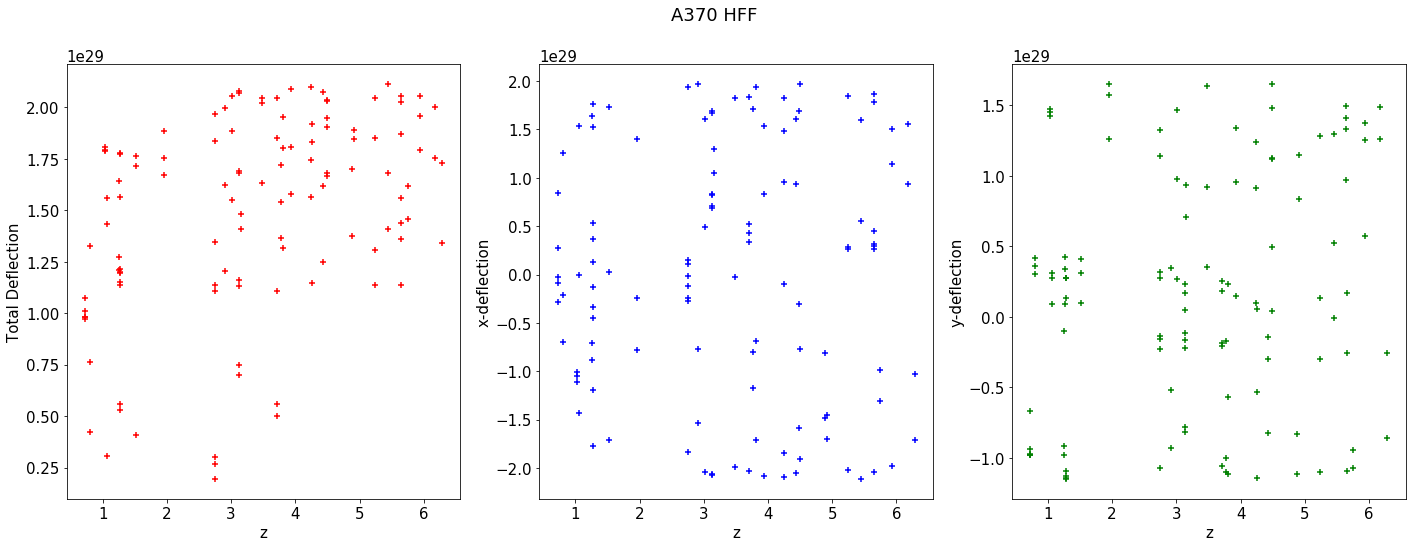

In [51]:
plt.rcParams.update({'font.size': 15})
std=np.zeros(N)

z=img['z']
avgdefl=np.average(defl,axis=2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(24,8))
fig.suptitle('A370 HFF')
ax1.scatter(z,np.sqrt(avgdefl[0]**2+avgdefl[1]**2),c='r',marker='+')
ax1.set(xlabel='z', ylabel='Total Deflection')
ax2.scatter(z,avgdefl[0],c='b',marker='+')
ax2.set(xlabel='z', ylabel='x-deflection')
ax3.scatter(z,avgdefl[1],c='g',marker='+')
ax3.set(xlabel='z', ylabel='y-deflection')

plt.show()

           2
-3.88e+26 x - 2.948e+25 x + 6.78e+27


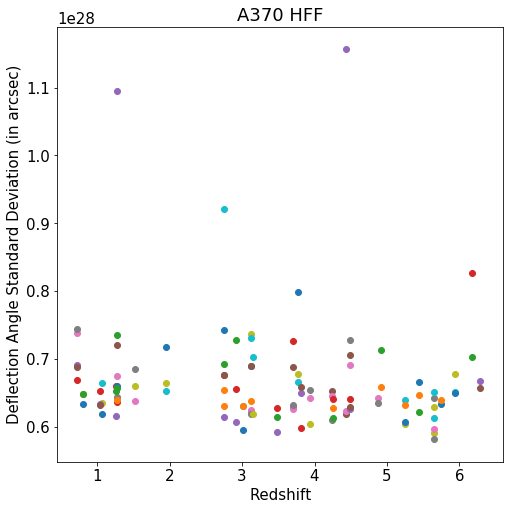

In [59]:
std_src = np.zeros((2,N))
std=np.zeros(N)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(N): 
    for j in range(40): 
        std_src[0,i]+=np.sqrt(abs(defl[0,i,j] - avgdefl[0,i])**2)/40
        std_src[1,i]+=np.sqrt(abs(defl[1,i,j] - avgdefl[1,i])**2)/40
    std[i]=np.sqrt(std_src[0,i]**2+std_src[1,i]**2)
#     print(std[i],img['z'][i])
    ax.scatter(img['z'][i],std[i])
    
z = np.polyfit(np.log10(img['z']), std,2)
xp = np.linspace(0.3, 8, 100)
p = np.poly1d(z)
print(p)
# plt.plot(xp, p(np.log10(xp)))
plt.axis()
# plt.yscale('log')
plt.title("A370 HFF")
plt.xlabel("Redshift")
plt.ylabel("Deflection Angle Standard Deviation (in arcsec)")
plt.show()